In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import cm
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
df = pd.read_csv('/content/heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Principal Component Analysis Results:

Component 	 Explained Variance 	 Cumulative Variance
----------------------------------------------------------------------
PC1 		 0.2358 			 0.2358
PC2 		 0.1123 			 0.3481
PC3 		 0.0880 			 0.4361
PC4 		 0.0862 			 0.5223
PC5 		 0.0730 			 0.5953
PC6 		 0.0693 			 0.6646
PC7 		 0.0617 			 0.7263
PC8 		 0.0554 			 0.7817
PC9 		 0.0521 			 0.8338
PC10 		 0.0445 			 0.8783
PC11 		 0.0382 			 0.9164
PC12 		 0.0307 			 0.9472
PC13 		 0.0266 			 0.9737
PC14 		 0.0263 			 1.0000


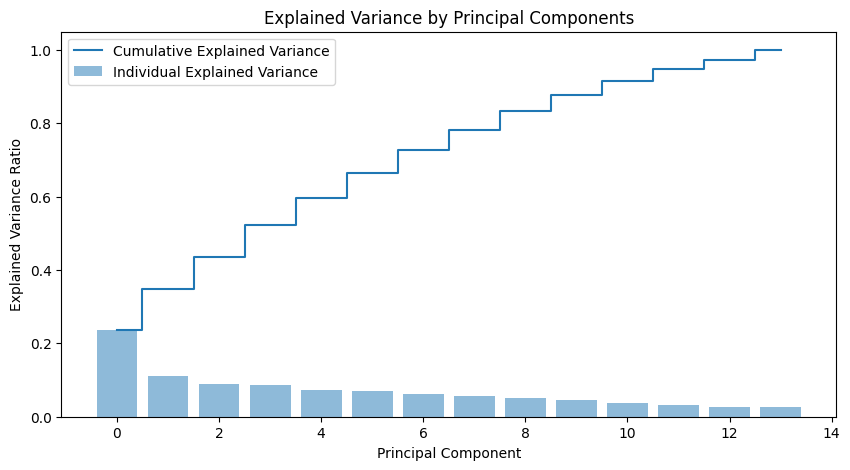

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Drop non-numerical columns if any
numerical_df = df.select_dtypes(include=[np.number])

# 1. Standardise the Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_df)

# 2. Apply PCA
pca = PCA()
pca_data = pca.fit_transform(scaled_data)

# 3. Visualize the Explained Variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("Principal Component Analysis Results:\n")
print("Component \t Explained Variance \t Cumulative Variance")
print("-" * 70)
for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):
    print(f"PC{i+1} \t\t {ev:.4f} \t\t\t {cv:.4f}")

plt.figure(figsize=(10, 5))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, label='Individual Explained Variance')
plt.step(range(len(cumulative_variance)), cumulative_variance, where='mid', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.show()


In [ ]:
threshold = 0.95
num_components = np.where(cumulative_variance > threshold)[0][0] + 1
print(f"\nNumber of components that explain at least {threshold*100}% of the variance: {num_components}")


Number of components that explain at least 95.0% of the variance: 13


In [ ]:
# List of continuous variables
continuous_vars = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

for col in continuous_vars:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Reset index after removing outliers
df.reset_index(drop=True, inplace=True)


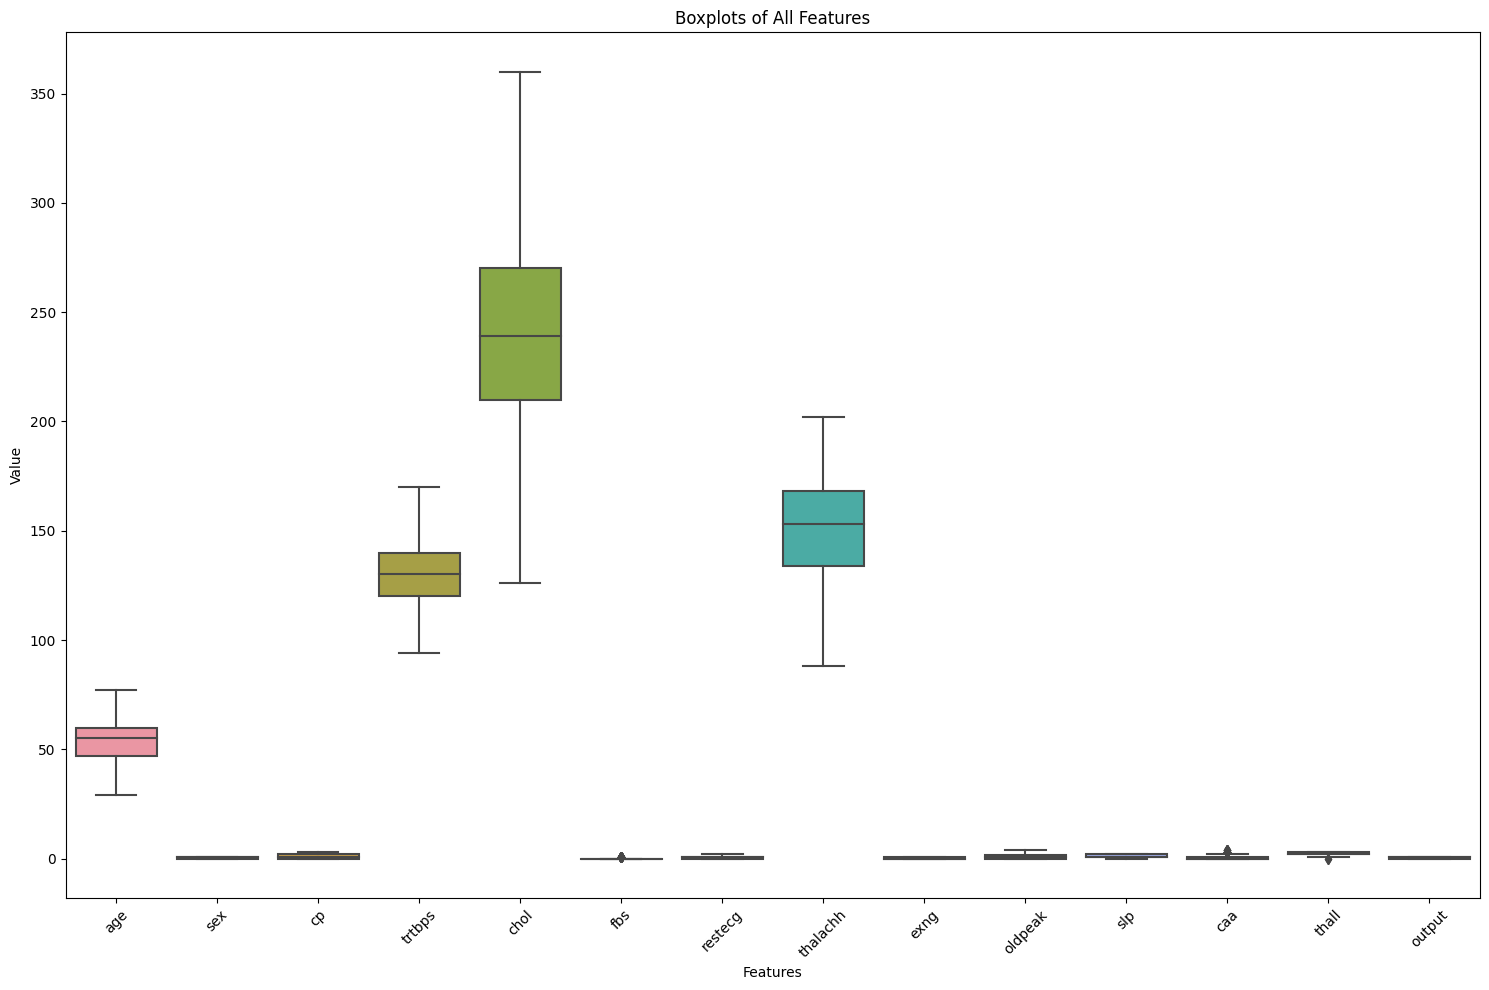

In [ ]:
plt.figure(figsize=(15, 10))

# Create a boxplot for all columns
sns.boxplot(data=df)

# Rotate x labels for better readability
plt.xticks(rotation=45)
plt.title('Boxplots of All Features')
plt.ylabel('Value')
plt.xlabel('Features')

plt.tight_layout()
plt.show()

In [ ]:
## Split training and testing split
X = df.drop('output', axis=1)
y = df['output']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE, SelectKBest, chi2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

std_scaler.fit(X_train)

# Standardize the numerical attributes in the training and testing sets
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

# Create new DataFrames with standardized numerical attributes
#X_train = pd.DataFrame(X_train_std, columns=X.columns)
#X_test = pd.DataFrame(X_test_std, columns=X.columns)

# 1. Feature Importance from Tree-based Models
models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

# Store feature importances
feature_importances = np.zeros(X_train_std.shape[1])

for model in models:
    model.fit(X_train_std, y_train)
    feature_importances += model.feature_importances_

# Average feature importances
feature_importances /= len(models)

# 2. RFE with Logistic Regression
estimator = LogisticRegression(max_iter=1000)
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X_train, y_train)
ranking_lr = selector.ranking_

# 3. SelectKBest with Naive Bayes
# Scale features to be non-negative for chi2
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Select top features
kbest = SelectKBest(chi2, k='all')
kbest.fit(X_train_scaled, y_train)
scores_nb = kbest.scores_

# Combine results to decide on final features
combined_scores = feature_importances + (1/ranking_lr) + scores_nb

# Get top features (e.g., top 10)
top_features = np.argsort(combined_scores)[::-1][:10]

print("Top features based on combined importance: ", top_features)


Top features based on combined importance:  [ 8  2 11  9  1 10  7 12  0  6]


In [ ]:
# List of feature names
feature_names = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output']

# Indices of top features
top_features = [8, 2, 11, 9, 1, 10, 7, 12, 0, 6]

# Map indices to feature names
top_feature_names = [feature_names[i] for i in top_features]

# Create a DataFrame to display the features in a table format
df_features = pd.DataFrame({
    'Rank': range(1, len(top_feature_names) + 1),
    'Feature': top_feature_names
})

df_features


,Rank,Feature
0,1,exng
1,2,cp
2,3,caa
3,4,oldpeak
4,5,sex
5,6,slp
6,7,thalachh
7,8,thall
8,9,age
9,10,restecg


In [ ]:
# Apply PCA
pca = PCA(n_components=13)
X_pca = pca.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define the models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'XgBoost': XGBClassifier(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'KNN': KNeighborsClassifier()
}

# I want to test the result with different n_component values
n_components_values = list(range(1, X_train.shape[1] + 1))

results_df = pd.DataFrame(index=n_components_values)

# Iterate over each n_components value
for n in n_components_values:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train and evaluate each model
    for name, model in models.items():
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        accuracy = accuracy_score(y_test, y_pred)
        results_df.loc[n, name] = accuracy

results_df


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

,Naive Bayes,Logistic Regression,Decision Tree,XgBoost,Random Forest,AdaBoost,KNN
1,0.524590,0.540984,0.590164,0.573770,0.590164,0.606557,0.524590
2,0.770492,0.770492,0.639344,0.770492,0.721311,0.704918,0.655738
3,0.754098,0.770492,0.655738,0.704918,0.688525,0.721311,0.688525
4,0.737705,0.770492,0.672131,0.672131,0.737705,0.704918,0.688525
5,0.819672,0.836066,0.754098,0.803279,0.803279,0.803279,0.688525
6,0.868852,0.852459,0.721311,0.836066,0.803279,0.819672,0.688525
7,0.852459,0.836066,0.704918,0.786885,0.786885,0.786885,0.688525
8,0.885246,0.868852,0.786885,0.868852,0.885246,0.770492,0.688525
9,0.918033,0.885246,0.786885,0.885246,0.868852,0.836066,0.688525
10,0.901639,0.885246,0.737705,0.852459,0.836066,0.852459,0.688525


Confusion Matrix for Naive Bayes:
[[21  5]
 [ 5 26]]
--------------------------------------------------
Confusion Matrix for Logistic Regression:
[[20  6]
 [ 5 26]]
--------------------------------------------------
Confusion Matrix for Decision Tree:
[[23  3]
 [ 5 26]]
--------------------------------------------------
Confusion Matrix for Random Forest:
[[20  6]
 [ 5 26]]
--------------------------------------------------
Confusion Matrix for KNN:
[[21  5]
 [ 5 26]]
--------------------------------------------------
Confusion Matrix for XGBoost:
[[20  6]
 [ 4 27]]
--------------------------------------------------
Confusion Matrix for AdaBoost:
[[19  7]
 [ 7 24]]
--------------------------------------------------


<ipython-input-22-70497ad2ed43>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(models.keys(), rotation=45, fontsize=8)


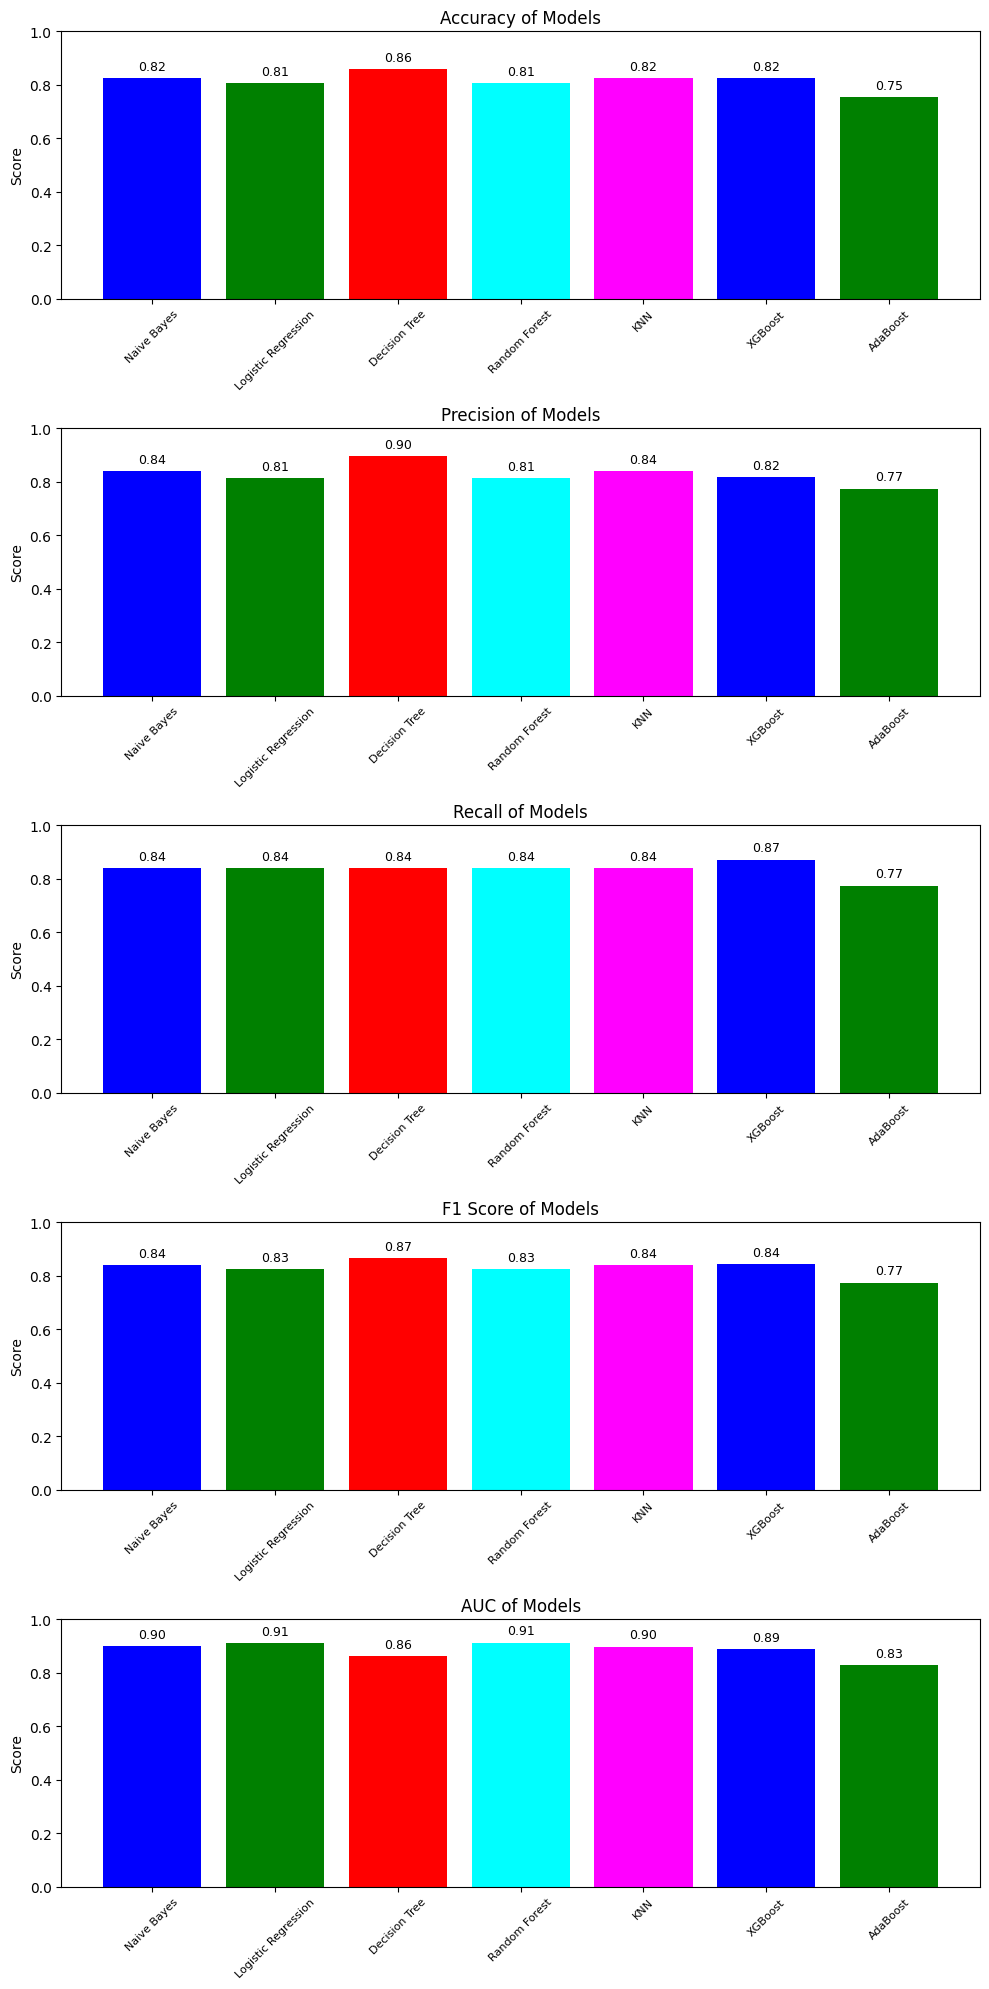

In [ ]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt


# Apply PCA with n_components=9
pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Define models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(random_state=1),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=10),
    'XGBoost': XGBClassifier(n_estimators=200, learning_rate=0.01, max_depth=3, subsample=0.7, colsample_bytree=0.5),
    'AdaBoost': AdaBoostClassifier(n_estimators=50)
}

# Dictionaries to store metrics
accuracy = {}
precisions = {}
recalls = {}
f1_scores = {}
AUC = {}

# Train, test, and evaluate models
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)

    # Store metrics
    accuracy[name] = accuracy_score(y_test, y_pred)
    precisions[name] = precision_score(y_test, y_pred)
    recalls[name] = recall_score(y_test, y_pred)
    f1_scores[name] = f1_score(y_test, y_pred)
    y_probs = model.predict_proba(X_test_pca)[:, 1]
    AUC[name] = roc_auc_score(y_test, y_probs)

    # Print confusion matrix
    print(f"Confusion Matrix for {name}:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)

# Visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
values = [list(accuracy.values()), list(precisions.values()), list(recalls.values()), list(f1_scores.values()), list(AUC.values())]

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))

for i, (metric, ax) in enumerate(zip(metrics, axes)):
    ax.bar(models.keys(), values[i], color=['blue', 'green', 'red', 'cyan', 'magenta'])
    ax.set_ylabel('Score')
    ax.set_title(f'{metric} of Models')
    ax.set_ylim(0, 1)
    ax.set_xticklabels(models.keys(), rotation=45, fontsize=8)
    for j, v in enumerate(values[i]):
        ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt


# Apply PCA with n_components=9
pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Define models
models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(random_state=1),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=10),
    'XGBoost': XGBClassifier(n_estimators=200, learning_rate=0.01, max_depth=3, subsample=0.7, colsample_bytree=0.5),
    'AdaBoost': AdaBoostClassifier(n_estimators=50)
}

# Dictionaries to store metrics
accuracy = {}
precisions = {}
recalls = {}
f1_scores = {}
AUC = {}

# Train, test, and evaluate models
for name, model in models.items():
    model.fit(X_train_pca, y_train)
    y_pred_train = model.predict(X_test_pca)

    # Store metrics
    accuracy[name] = accuracy_score(y_test, y_pred)
    precisions[name] = precision_score(y_test, y_pred)
    recalls[name] = recall_score(y_test, y_pred)
    f1_scores[name] = f1_score(y_test, y_pred)
    y_probs = model.predict_proba(X_test_pca)[:, 1]
    AUC[name] = roc_auc_score(y_test, y_probs)

    # Print confusion matrix
    print(f"Confusion Matrix for {name}:")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)

# Visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
values = [list(accuracy.values()), list(precisions.values()), list(recalls.values()), list(f1_scores.values()), list(AUC.values())]

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))

for i, (metric, ax) in enumerate(zip(metrics, axes)):
    ax.bar(models.keys(), values[i], color=['blue', 'green', 'red', 'cyan', 'magenta'])
    ax.set_ylabel('Score')
    ax.set_title(f'{metric} of Models')
    ax.set_ylim(0, 1)
    ax.set_xticklabels(models.keys(), rotation=45, fontsize=8)
    for j, v in enumerate(values[i]):
        ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


Here are the ranks of significant features in the dataset

In [ ]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
features = ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall']

# Initialise the models
etc = ExtraTreesClassifier()
gbc = GradientBoostingClassifier()
rf = RandomForestClassifier()
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=1)
xgb = XGBClassifier()

# Fit the models and get feature importances
etc.fit(X, y)
gbc.fit(X, y)
rf.fit(X, y)
rfe.fit(X, y)
xgb.fit(X, y)

# Create a DataFrame to store feature importances
importances = pd.DataFrame({
    'Attributes': features,
    'ETC': etc.feature_importances_,
    'GBC': gbc.feature_importances_,
    'RF': rf.feature_importances_,
    'RFE': rfe.ranking_,  # For RFE, lower ranking is better
    'XGB': xgb.feature_importances_
})

# Calculate the mean importance score for each feature
importances['MEAN'] = importances[['ETC', 'GBC', 'RF', 'RFE', 'XGB']].mean(axis=1)

# Sort the DataFrame based on the mean importance score
importances = importances.sort_values(by='MEAN', ascending=False)

# Display the table
print("Table 1")
print("Feature selection techniques providing weight to each risk attribute.")
print(importances)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Table 1
Feature selection techniques providing weight to each risk attribute.
   Attributes       ETC       GBC        RF  RFE       XGB      MEAN
4        chol  0.061933  0.052061  0.068389   13  0.026637  2.641804
0         age  0.065288  0.079547  0.086385   12  0.038006  2.453845
5         fbs  0.019104  0.000346  0.010657   11  0.034018  2.212825
3      trtbps  0.060992  0.039730  0.074882   10  0.029416  2.041004
7    thalachh  0.095329  0.052192  0.120205    9  0.029622  1.859470
6     restecg  0.035063  0.010510  0.018547    8  0.029869  1.618798
9     oldpeak  0.091855  0.103792  0.112074    7  0.065899  1.474724
2          cp  0.127453  0.260792  0.124571    6  0.229090  1.348381
11        caa  0.117566  0.153213  0.114422    5  0.138294  1.104699
12      thall  0.100296  0.136331  0.106604    4  0.180093  0.904665
10        slp  0.072386  0.048468  0.052478    3  0.059119  0.646490
1         sex  0.056553  0.037270  0.038735    2  0.051821  0.436876
8        exng  0.096182  

### The metrics showed a good performance from all models using PCA, however, the False Negative rate in the confusion matrix is too high in the context that we want to predict heart disease. False diagnosis can lead to fatal consequence for people.

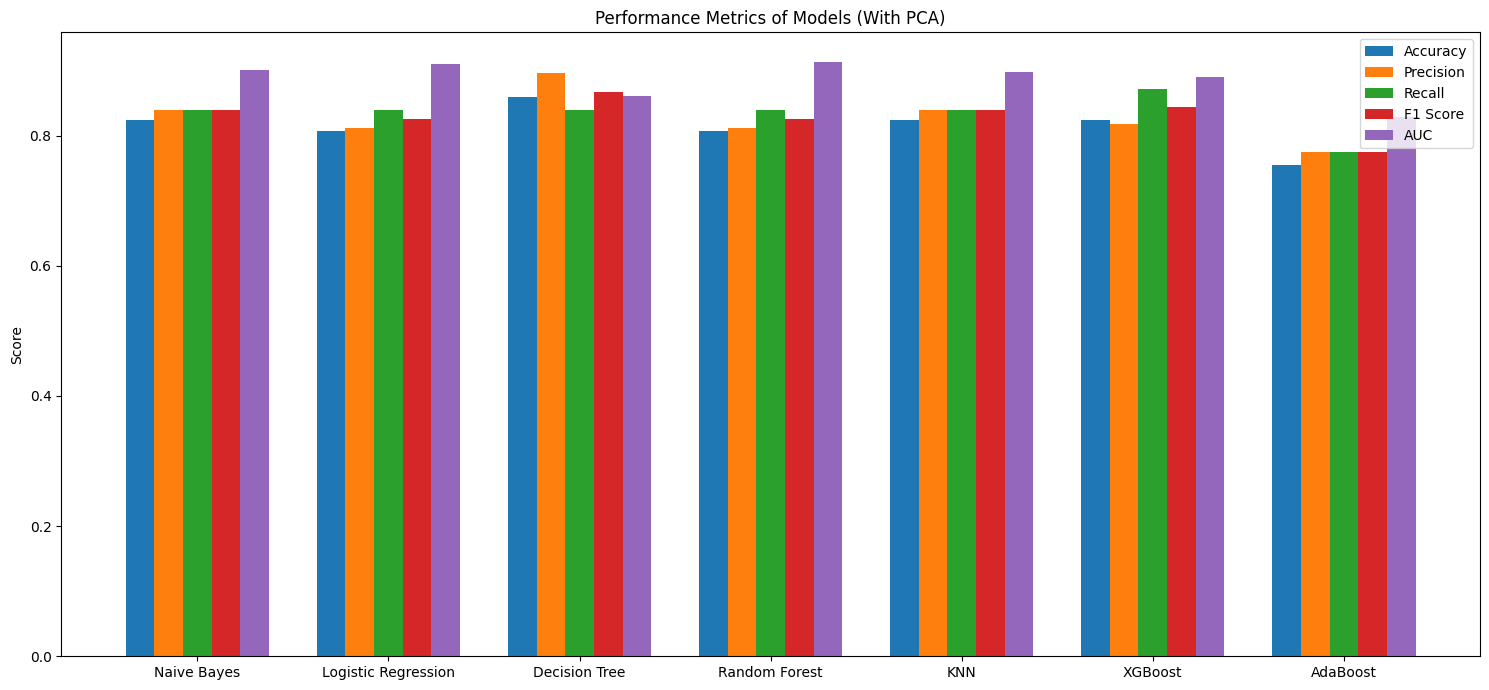

In [ ]:
import matplotlib.pyplot as plt

models = list(accuracy.keys())
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
values = [list(accuracy.values()), list(precisions.values()), list(recalls.values()), list(f1_scores.values()), list(AUC.values())]

fig, ax = plt.subplots(figsize=(15, 7))

# Plotting each metric
for i, metric in enumerate(metrics):
    ax.bar([x + i*0.15 for x in range(len(models))], values[i], width=0.15, label=metric)

ax.set_ylabel('Score')
ax.set_title('Performance Metrics of Models (With PCA)')
ax.set_xticks([x + 0.3 for x in range(len(models))])
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
precisions


{'Naive Bayes': 0.8387096774193549,
 'Logistic Regression': 0.8125,
 'Decision Tree': 0.896551724137931,
 'Random Forest': 0.8125,
 'KNN': 0.8387096774193549,
 'XGBoost': 0.8181818181818182,
 'AdaBoost': 0.7741935483870968}

In [ ]:
accuracy

{'Naive Bayes': 0.8245614035087719,
 'Logistic Regression': 0.8070175438596491,
 'Decision Tree': 0.8596491228070176,
 'Random Forest': 0.8070175438596491,
 'KNN': 0.8245614035087719,
 'XGBoost': 0.8245614035087719,
 'AdaBoost': 0.7543859649122807}

In [ ]:
recalls

{'Naive Bayes': 0.8387096774193549,
 'Logistic Regression': 0.8387096774193549,
 'Decision Tree': 0.8387096774193549,
 'Random Forest': 0.8387096774193549,
 'KNN': 0.8387096774193549,
 'XGBoost': 0.8709677419354839,
 'AdaBoost': 0.7741935483870968}

In [ ]:
f1_scores

{'Naive Bayes': 0.8387096774193549,
 'Logistic Regression': 0.8253968253968254,
 'Decision Tree': 0.8666666666666666,
 'Random Forest': 0.8253968253968254,
 'KNN': 0.8387096774193549,
 'XGBoost': 0.84375,
 'AdaBoost': 0.7741935483870968}

In [ ]:
AUC

{'Naive Bayes': 0.9007444168734491,
 'Logistic Regression': 0.9106699751861043,
 'Decision Tree': 0.8616625310173697,
 'Random Forest': 0.913151364764268,
 'KNN': 0.8976426799007444,
 'XGBoost': 0.8895781637717122,
 'AdaBoost': 0.8287841191066997}

In [ ]:
data = {'accuracy': accuracy, 'recalls': recalls, 'precisions': precisions, 'f1_scores': f1_scores, 'AUC': AUC}

model = pd.DataFrame(data, index=['Naive Bayes', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'KNN', 'XGBoost', 'AdaBoost'])
model

,accuracy,recalls,precisions,f1_scores,AUC
Naive Bayes,0.824561,0.838710,0.838710,0.838710,0.900744
Logistic Regression,0.807018,0.838710,0.812500,0.825397,0.910670
Decision Tree,0.859649,0.838710,0.896552,0.866667,0.861663
Random Forest,0.807018,0.838710,0.812500,0.825397,0.913151
KNN,0.824561,0.838710,0.838710,0.838710,0.897643
XGBoost,0.824561,0.870968,0.818182,0.843750,0.889578
AdaBoost,0.754386,0.774194,0.774194,0.774194,0.828784


In [ ]:
# Convert RFE rankings to importance scores (inverse of ranking)
importances['RFE'] = 1 / importances['RFE']

# Re-calculate the mean importance score
importances['MEAN'] = importances[['ETC', 'GBC', 'RF', 'RFE', 'XGB']].mean(axis=1)

# Sort the DataFrame based on the mean importance score
importances = importances.sort_values(by='MEAN', ascending=False)

# Display the table
print("Table 1")
print("Feature selection techniques providing weight to each risk attribute.")
print(importances.to_string(index=False))


Table 1
Feature selection techniques providing weight to each risk attribute.
Attributes      ETC      GBC       RF      RFE      XGB     MEAN
      exng 0.096182 0.025749 0.072051 1.000000 0.088115 0.256419
        cp 0.127453 0.260792 0.124571 0.166667 0.229090 0.181715
     thall 0.100296 0.136331 0.106604 0.250000 0.180093 0.154665
       caa 0.117566 0.153213 0.114422 0.200000 0.138294 0.144699
       sex 0.056553 0.037270 0.038735 0.500000 0.051821 0.136876
       slp 0.072386 0.048468 0.052478 0.333333 0.059119 0.113157
   oldpeak 0.091855 0.103792 0.112074 0.142857 0.065899 0.103295
  thalachh 0.095329 0.052192 0.120205 0.111111 0.029622 0.081692
       age 0.065288 0.079547 0.086385 0.083333 0.038006 0.070512
    trtbps 0.060992 0.039730 0.074882 0.100000 0.029416 0.061004
      chol 0.061933 0.052061 0.068389 0.076923 0.026637 0.057189
   restecg 0.035063 0.010510 0.018547 0.125000 0.029869 0.043798
       fbs 0.019104 0.000346 0.010657 0.090909 0.034018 0.031007


# Cross-validation of Models of Different Subsets of Data

I want to see the cross validation with three different splits from the original dataset based on the attributes weight result from above.

## Subset 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

std_scaler.fit(X_train)

# Standardise the numerical attributes in the training and testing sets
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

models = [
    ('Logistic Regression', LogisticRegression(max_iter=10000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('XGBoost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('Naive Bayes', GaussianNB())
]

# 4. Cross-Validation: Perform cross-validation on each model using the training set
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    cv_scores = cross_val_score(model, X_train_std, y_train, cv=10, scoring=scoring)
    results.append(cv_scores)
    names.append(name)
    print(f"{name}: {cv_scores.mean():.4f} ({cv_scores.std():.4f})")

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Logistic Regression: 0.8186 (0.0932)
KNN: 0.8411 (0.0821)
Decision Tree: 0.7581 (0.0936)
Random Forest: 0.8103 (0.1086)
AdaBoost: 0.7800 (0.0904)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarnin

XGBoost: 0.8014 (0.1117)
Naive Bayes: 0.8322 (0.0711)


## Subset 2


In [ ]:
## Split new training and testing split
new_df = df.drop(['slp', 'oldpeak', 'thalachh', 'age', 'trtbps', 'chol', 'restecg', 'fbs'], axis=1)
X2 = new_df.drop('output', axis=1)
y2 = new_df['output']

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

std_scaler = StandardScaler()

std_scaler.fit(X_train2)
X_train_std2 = std_scaler.fit_transform(X_train2)
X_test_std2 = std_scaler.transform(X_test2)

models = [
    ('Logistic Regression', LogisticRegression(max_iter=10000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('XGBoost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('Naive Bayes', GaussianNB())
]

results = []
names = []
scoring = 'accuracy'

for name, model in models:
    cv_scores2 = cross_val_score(model, X_train_std2, y_train2, cv=10, scoring=scoring)
    results.append(cv_scores2)
    names.append(name)
    print(f"{name}: {cv_scores2.mean():.4f} ({cv_scores2.std():.4f})")

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Logistic Regression: 0.8144 (0.0722)
KNN: 0.7881 (0.0796)
Decision Tree: 0.7488 (0.1142)
Random Forest: 0.7842 (0.1051)
AdaBoost: 0.8231 (0.0615)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarnin

XGBoost: 0.7356 (0.0919)
Naive Bayes: 0.8051 (0.0745)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


## Subset 3

In [ ]:
## Split new training and testing split
new_df3 = df.drop(['trtbps', 'chol', 'fbs'], axis=1)
X3 = new_df3.drop('output', axis=1)
y3 = new_df3['output']

In [ ]:
new_df3.head(5)

,age,sex,cp,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,0,150,0,2.3,0,0,1,1
1,37,1,2,1,187,0,3.5,0,0,2,1
2,41,0,1,0,172,0,1.4,2,0,2,1
3,56,1,1,1,178,0,0.8,2,0,2,1
4,57,0,0,1,163,1,0.6,2,0,2,1


In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.2, random_state=42)

std_scaler = StandardScaler()

std_scaler.fit(X_train3)

X_train_std3 = std_scaler.fit_transform(X_train3)
X_test_std3 = std_scaler.transform(X_test3)

models = [
    ('Logistic Regression', LogisticRegression(max_iter=10000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('XGBoost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('Naive Bayes', GaussianNB())
]

results = []
names = []
scoring = 'accuracy'

for name, model in models:
    cv_scores3 = cross_val_score(model, X_train_std3, y_train3, cv=10, scoring=scoring)
    results.append(cv_scores3)
    names.append(name)
    print(f"{name}: {cv_scores3.mean():.4f} ({cv_scores3.std():.4f})")

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Logistic Regression: 0.8144 (0.0853)
KNN: 0.8150 (0.0940)
Decision Tree: 0.7366 (0.1087)
Random Forest: 0.8279 (0.1088)
AdaBoost: 0.7836 (0.1053)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarnin

XGBoost: 0.8018 (0.1130)
Naive Bayes: 0.8277 (0.0733)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


###With these different subsets, all the models performed poorly, compared with using the original dataset.